In [1]:
# Allow us to load `open_cp` without installing
import sys, os.path
sys.path.insert(0, os.path.abspath(os.path.join("..","..")))

# Explore the geo-coding of the chicago dataset

The chicago crime data provides both:

- block-level addresses, sanitised to the form "010XX N CENTRAL PARK AVE"
- location data in "coordinates" and "longitude/latitude"

We shall see that the coordinates and lon/lat data are linked by projecting in EPSG:3435.  However, the relationship between the block-level addresses and the coordinates is complicated, to say the least.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import os, lzma

import open_cp.sources.chicago as chicago

# Check the projection

Our library does not return the "coordinates", so we shall manually read them from the CSV file and join them.

A bit of browsing around lead me to [EPSG 3435](http://spatialreference.org/ref/epsg/3435/) which is "NAD83 / Illinois East (ftUS)"

- Of note is that this website says the data is in "US feet"
- Out of the box, this just doesn't work.
- But if I manually correct for the units (i.e. convert from meters to US feet) then it gives an exact agreement.

Here, by "exact" agreement we mean actual equality, once we round to the nearest foot.

- Going the other way, and starting with the x/y coords and projecting back to longitude / latitude leads to small rounding errors.

This suggests that the lon/lat data is "primary", and the coordinates are computed from it.

In [3]:
# Set "empty_geometry" to allow us to re-project; but we cannot save such a file!
frame = chicago.load_to_geoDataFrame(empty_geometry="empty")
frame.head()

,address,case,crime,geometry,location,timestamp,type
0,010XX N CENTRAL PARK AVE,HZ560767,OTHER OFFENSE,POINT (-87.71645415899999 41.899712716),APARTMENT,2016-12-22T02:55:00,VIOLATE ORDER OF PROTECTION
1,051XX S WASHTENAW AVE,HZ561134,BATTERY,POINT (-87.691539994 41.800445234),RESIDENTIAL YARD (FRONT/BACK),2016-12-22T11:17:00,AGGRAVATED: OTHER FIREARM
2,059XX W DIVERSEY AVE,HZ565584,DECEPTIVE PRACTICE,POINT (-87.774165121 41.931166274),RESIDENCE,2016-12-09T12:00:00,FINANCIAL IDENTITY THEFT $300 AND UNDER
3,001XX N STATE ST,HZ561772,THEFT,POINT (-87.62787669799999 41.883500187),DEPARTMENT STORE,2016-12-22T18:50:00,RETAIL THEFT
4,008XX N MICHIGAN AVE,HZ561969,THEFT,POINT (-87.624095634 41.897982937),SMALL RETAIL STORE,2016-12-22T19:20:00,RETAIL THEFT


In [4]:
import csv

xcoords, ycoords = [], []
with open(chicago._default_filename, "rt") as file:
    reader = csv.reader(file)
    header = next(reader)
    xi = header.index("X COORDINATE")
    yi = header.index("Y COORDINATE")
    for row in reader:
        if row[xi] is not "":
            xcoords.append(int(row[xi]))
            ycoords.append(int(row[yi]))
        else:
            xcoords.append(None)
            ycoords.append(None)

frame["xcoord"] = xcoords
frame["ycoord"] = ycoords
frame.head()

,address,case,crime,geometry,location,timestamp,type,xcoord,ycoord
0,010XX N CENTRAL PARK AVE,HZ560767,OTHER OFFENSE,POINT (-87.71645415899999 41.899712716),APARTMENT,2016-12-22T02:55:00,VIOLATE ORDER OF PROTECTION,1152189.0,1906649.0
1,051XX S WASHTENAW AVE,HZ561134,BATTERY,POINT (-87.691539994 41.800445234),RESIDENTIAL YARD (FRONT/BACK),2016-12-22T11:17:00,AGGRAVATED: OTHER FIREARM,1159242.0,1870526.0
2,059XX W DIVERSEY AVE,HZ565584,DECEPTIVE PRACTICE,POINT (-87.774165121 41.931166274),RESIDENCE,2016-12-09T12:00:00,FINANCIAL IDENTITY THEFT $300 AND UNDER,1136403.0,1918003.0
3,001XX N STATE ST,HZ561772,THEFT,POINT (-87.62787669799999 41.883500187),DEPARTMENT STORE,2016-12-22T18:50:00,RETAIL THEFT,1176352.0,1900927.0
4,008XX N MICHIGAN AVE,HZ561969,THEFT,POINT (-87.624095634 41.897982937),SMALL RETAIL STORE,2016-12-22T19:20:00,RETAIL THEFT,1177338.0,1906213.0


In [5]:
# Check geometry is empty if and only if coords are
geo_null = frame.geometry.map(lambda pt : pt.is_empty)
np.all(frame.xcoord.isnull() == geo_null), np.all(frame.ycoord.isnull() == geo_null), np.sum(~geo_null)

(True, True, 254965)

In [6]:
frame = frame.dropna()
len(frame)

254965

In [7]:
# The x/y coordinates are integers in the CSV, so treat them as such
frame.xcoord = frame.xcoord.astype(np.int)
frame.ycoord = frame.ycoord.astype(np.int)

In [8]:
# Backup the lon/lat coords and the project
frame["coords"] = frame.geometry.copy()
frame = frame.to_crs({'init': 'epsg:3435', "preserve_units":True})

In [9]:
np.max((frame.xcoord - frame.geometry.map(lambda pt : pt.coords[0][0]))**2
    + (frame.ycoord - frame.geometry.map(lambda pt : pt.coords[0][1]))**2)

5.2056829767243174e-08

### Rounding

Suppose we round the projected coordinates to the nearest foot.  We find that we get an _exact_ agreement.

In [10]:
np.all( frame.xcoord - np.round(frame.geometry.map(lambda pt : pt.coords[0][0])) == 0 )

True

In [11]:
np.all( frame.ycoord - np.round(frame.geometry.map(lambda pt : pt.coords[0][1])) == 0 )

True

### Starting with projectd coordinates

Suppose instead we start with the projected coordinates, and convert these back to lon/lat.  In the CSV file, the lon/lat coords are rounded to 9 decimal places.  We find that there are small rounding errors in this case.

In [12]:
import shapely.geometry

frame.geometry = [shapely.geometry.Point(x,y) for x, y in zip(frame.xcoord, frame.ycoord)]

In [13]:
frame = frame.to_crs({'init': 'epsg:4326'})
frame.head()

,address,case,crime,geometry,location,timestamp,type,xcoord,ycoord,coords
0,010XX N CENTRAL PARK AVE,HZ560767,OTHER OFFENSE,POINT (-87.71645415873341 41.89971271596254),APARTMENT,2016-12-22T02:55:00,VIOLATE ORDER OF PROTECTION,1152189,1906649,POINT (-87.71645415899999 41.899712716)
1,051XX S WASHTENAW AVE,HZ561134,BATTERY,POINT (-87.69153999399755 41.8004452337576),RESIDENTIAL YARD (FRONT/BACK),2016-12-22T11:17:00,AGGRAVATED: OTHER FIREARM,1159242,1870526,POINT (-87.691539994 41.800445234)
2,059XX W DIVERSEY AVE,HZ565584,DECEPTIVE PRACTICE,POINT (-87.77416512059659 41.93116627430756),RESIDENCE,2016-12-09T12:00:00,FINANCIAL IDENTITY THEFT $300 AND UNDER,1136403,1918003,POINT (-87.774165121 41.931166274)
3,001XX N STATE ST,HZ561772,THEFT,POINT (-87.62787669753108 41.88350018711407),DEPARTMENT STORE,2016-12-22T18:50:00,RETAIL THEFT,1176352,1900927,POINT (-87.62787669799999 41.883500187)
4,008XX N MICHIGAN AVE,HZ561969,THEFT,POINT (-87.62409563378577 41.89798293721393),SMALL RETAIL STORE,2016-12-22T19:20:00,RETAIL THEFT,1177338,1906213,POINT (-87.624095634 41.897982937)


In [14]:
frame[frame.coords.map(lambda pt : pt.coords[0][0]) !=
      frame.geometry.map(lambda pt : float("{:.9f}".format(pt.coords[0][0] )))].head()

,address,case,crime,geometry,location,timestamp,type,xcoord,ycoord,coords
97005,013XX W ANCONA ST,HZ379958,BATTERY,POINT (-87.66050584649999 41.89391280219293),RESIDENCE PORCH/HALLWAY,2016-08-05T19:55:00,AGGRAVATED: OTHER DANG WEAPON,1167437,1904650,POINT (-87.660505847 41.893912802)
132485,061XX W EDDY ST,HZ490603,BATTERY,POINT (-87.78022858449999 41.94481522745974),RESIDENCE,2016-10-26T21:00:00,AGGRAVATED DOMESTIC BATTERY: OTHER DANG WEAPON,1134721,1922966,POINT (-87.780228585 41.944815227)
137638,013XX W ANCONA ST,JA157851,THEFT,POINT (-87.66050584649999 41.89391280219293),RESIDENTIAL YARD (FRONT/BACK),2017-02-16T10:30:00,OVER $500,1167437,1904650,POINT (-87.660505847 41.893912802)
152276,013XX W ANCONA ST,JA167559,BURGLARY,POINT (-87.66050584649999 41.89391280219293),RESIDENCE,2017-02-25T19:00:00,UNLAWFUL ENTRY,1167437,1904650,POINT (-87.660505847 41.893912802)
152867,013XX W ANCONA ST,JA167123,CRIMINAL DAMAGE,POINT (-87.66050584649999 41.89391280219293),APARTMENT,2017-02-25T17:54:00,TO PROPERTY,1167437,1904650,POINT (-87.660505847 41.893912802)


# Visualise the geocoding

We'll use [TileMapBase](https://github.com/MatthewDaws/TileMapBase) to visualise where the coordinates land.  Use EPSG:3857 to conform the "web mercator" projection.

(Sadly, plotting from geoPandas seems very slow.  So we cheat, and use some knowledge.)

In [15]:
import tilemapbase
tilemapbase.start_logging()

In [16]:
frame = chicago.load_to_geoDataFrame().dropna()
frame = frame.to_crs({"init":"EPSG:3857"})

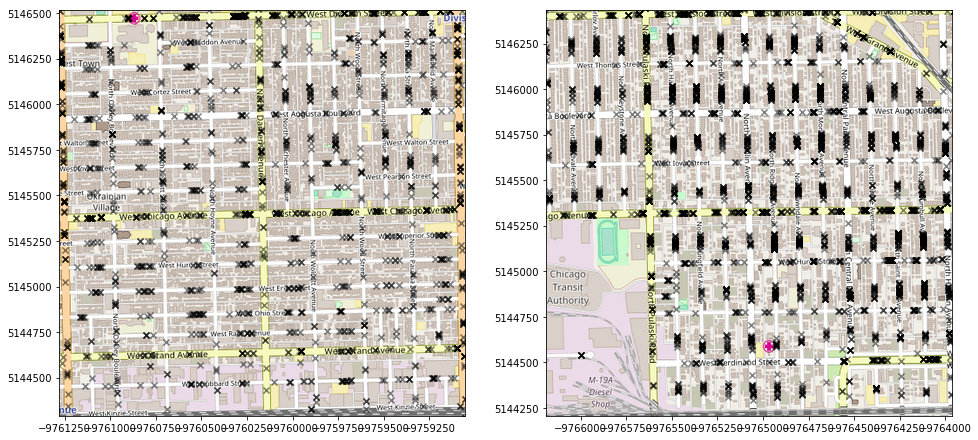

In [17]:
lat, lon = 41.895937, -87.677092
region = 0.01

extent1 = tilemapbase.extent(lon-region, lon+region, lat-region, lat+region, 500, 500)
extent1.project_3857()

lat, lon = 41.895379, -87.721192
extent2 = tilemapbase.extent(lon-region, lon+region, lat-region, lat+region, 500, 500)
extent2.project_3857()

fig, ax = plt.subplots(ncols=2, figsize=(16,8))
extent1.plothq(ax[0], tilemapbase.tiles.OSM)
extent2.plothq(ax[1], tilemapbase.tiles.OSM)

x = frame.geometry.map(lambda pt : pt.coords[0][0])
y = frame.geometry.map(lambda pt : pt.coords[0][1])
ax[0].scatter(x, y, color="black", marker="x", alpha=0.5)
ax[1].scatter(x, y, color="black", marker="x", alpha=0.5)
None

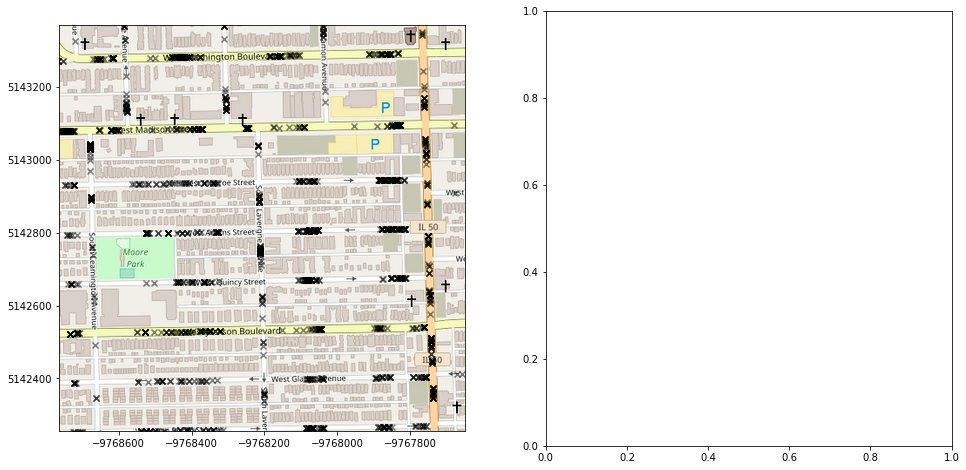

In [18]:
lat, lon = 41.8786, -87.7493
region = 0.005
extent1 = tilemapbase.extent(lon-region, lon+region, lat-region, lat+region, 500, 500)
extent1.project_3857()

fig, ax = plt.subplots(ncols=2, figsize=(16,8))
extent1.plothq(ax[0], tilemapbase.tiles.OSM)
ax[0].scatter(x, y, color="black", marker="x", alpha=0.5)
None

# Re-create plots from Rosser, Cheng

Let us try to recreate the plots from page 3 (Figure 1) of:

- Rosser, Cheng, "Improving the Robustness and Accuracy of Crime Prediction with the Self-Exciting Point Process Through Isotropic Triggering" Appl. Spatial Analysis DOI:10.1007/s12061-016-9198-y

   > For the purposes of this study, we use open access crime data records from the City of
Chicago covering a 1 year period starting on 1st March 2011

In [19]:
import datetime

filename_all = os.path.join("..", "..", "open_cp", "sources", "chicago_all.csv.xz")

def in_time_range(time_string):
    dt = datetime.datetime.strptime(time_string, "%Y-%m-%dT%H:%M:%S")
    delta = dt - datetime.datetime(2011, 3, 1)
    return delta >= datetime.timedelta(0) and delta <= datetime.timedelta(days=365)

with lzma.open(filename_all, "rt") as file:
    data2011 = [ event for event in chicago.generate_GeoJSON_Features(file, type="all")
                if event["properties"]["crime"] == "BURGLARY"
                    and in_time_range(event["properties"]["timestamp"]) ]

data2011 = gpd.GeoDataFrame.from_features(data2011)
data2011.crs = {"init":"EPSG:4326"} # Lon/Lat native coords
data2011.head()

,address,case,crime,geometry,location,timestamp,type
0,010XX N HAMLIN AVE,HT346569,BURGLARY,POINT (-87.72134357 41.900059954),RESIDENCE,2011-06-13T17:30:00,FORCIBLE ENTRY
1,105XX S CORLISS AVE,HT457173,BURGLARY,None,VACANT LOT/LAND,2011-08-10T15:15:00,FORCIBLE ENTRY
2,023XX E 70TH ST,HT183222,BURGLARY,POINT (-87.567306284 41.768069819),APARTMENT,2011-03-01T00:45:00,HOME INVASION
3,0000X S WESTERN AVE,HT183281,BURGLARY,POINT (-87.68642135499999 41.880842701),SMALL RETAIL STORE,2011-03-01T04:07:00,FORCIBLE ENTRY
4,054XX W DEVON AVE,HT183321,BURGLARY,POINT (-87.764348762 41.997327626),RESTAURANT,2011-03-01T01:40:00,FORCIBLE ENTRY


In [20]:
data2011 = data2011.dropna()
data2011 = data2011.to_crs({"init":"EPSG:3857"})

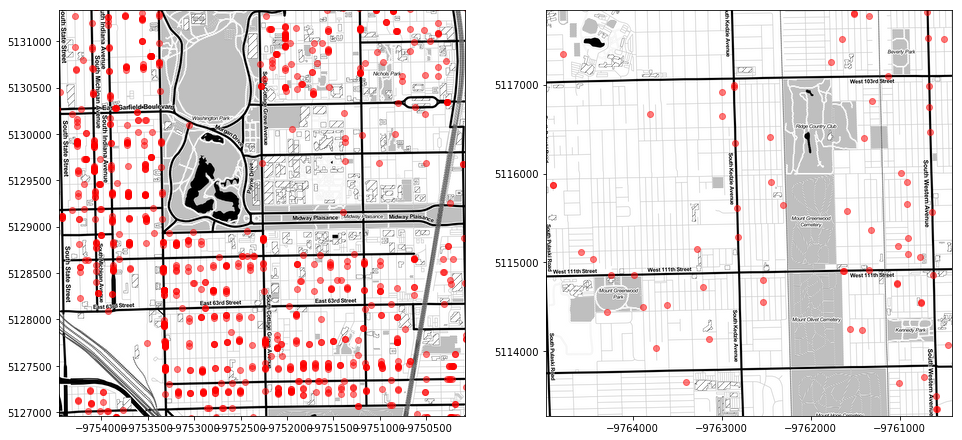

In [21]:
top, left = 41.8019, -87.6258
bottom, right = 41.7724, -87.5865
region = max(top - bottom, right - left) / 2
lon, lat = (left + right)/2, (top + bottom)/2
extent1 = tilemapbase.extent(lon-region, lon+region, lat-region, lat+region, 500, 500)
extent1.project_3857()

top, left = 41.7125, -87.7203
bottom, right = 41.6796, -87.6793
region = max(top - bottom, right - left) / 2
lon, lat = (left + right)/2, (top + bottom)/2
extent2 = tilemapbase.extent(lon-region, lon+region, lat-region, lat+region, 500, 500)
extent2.project_3857()

fig, ax = plt.subplots(ncols=2, figsize=(16,8))
extent1.zoom += 1
extent1.plothq(ax[0], tilemapbase.tiles.Stamen_Toner)
extent2.zoom += 1
extent2.plothq(ax[1], tilemapbase.tiles.Stamen_Toner)

x = data2011.geometry.map(lambda pt : pt.coords[0][0])
y = data2011.geometry.map(lambda pt : pt.coords[0][1])
ax[0].scatter(x, y, color="red", marker="o", alpha=0.5)
ax[1].scatter(x, y, color="red", marker="o", alpha=0.5)
None

# Explore unusual encoding issues

These have been discovered from the work on the other notebook, trying to link the points to "edges" in the TIGER address dataset from the US Census Bureau.

In [22]:
def plot_block(block_name, buffer, ax):
    block = frame[frame.address==block_name]
    extent = tilemapbase.extent_from_frame(block, 600, buffer)
    extent.plothq(ax, tilemapbase.tiles.OSM, alpha=0.7)
    x = block.geometry.map(lambda pt : pt.coords[0][0])
    y = block.geometry.map(lambda pt : pt.coords[0][1])
    ax.scatter(x, y, color="black", marker="x", alpha=1)

### Split roads

Where the east/west (or north/south) lanes of a major road are divided.  Are the 2 sets of events really disjoint?

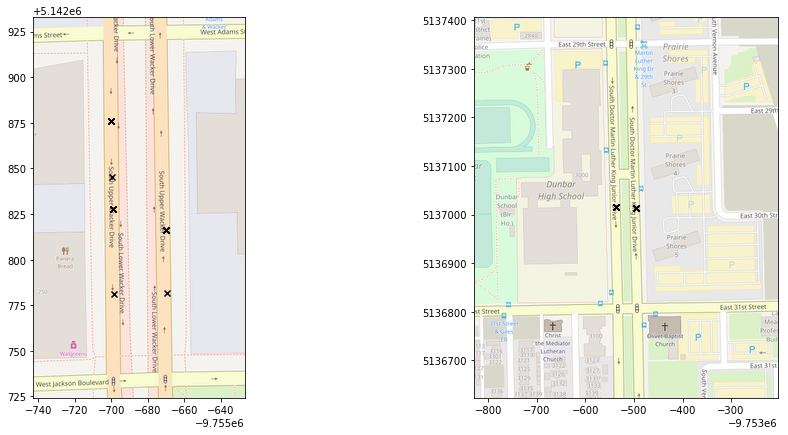

In [23]:
fig, ax = plt.subplots(ncols=2, figsize=(16,7))
plot_block('002XX S WACKER DR', 60, ax[0])
plot_block('030XX S DR MARTIN LUTHER KING JR DR', 700, ax[1])

### What look like errors in the dataset

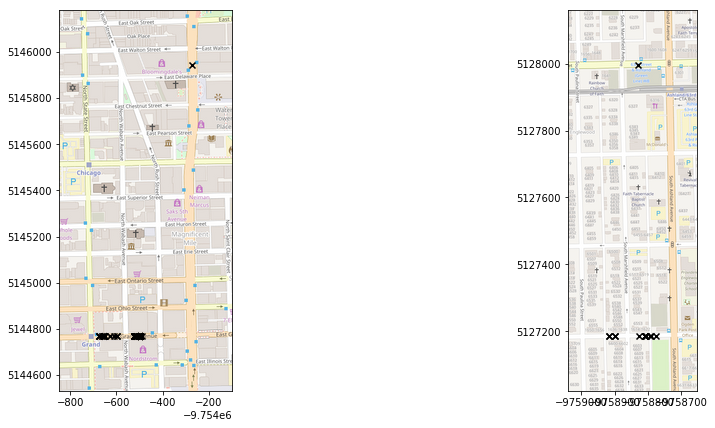

In [24]:
fig, ax = plt.subplots(ncols=2, figsize=(16,7))
plot_block('0000X E GRAND AVE', 20, ax[0])
plot_block('016XX W 66TH ST', 20, ax[1])

### Where the geocoding disagrees with OpenStreetMap

Here we mis-align with roads, but this appears to be a disagreement between the TIGER data and OSM.

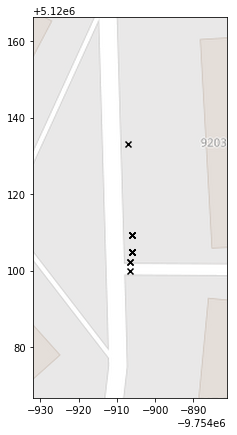

In [25]:
fig, ax = plt.subplots(ncols=1, figsize=(16,7))
plot_block('092XX S PRINCETON AVE', 100, ax)

### Unusual geography

Especially in the 1st plot, are we meant to infer anything from the coordinates?

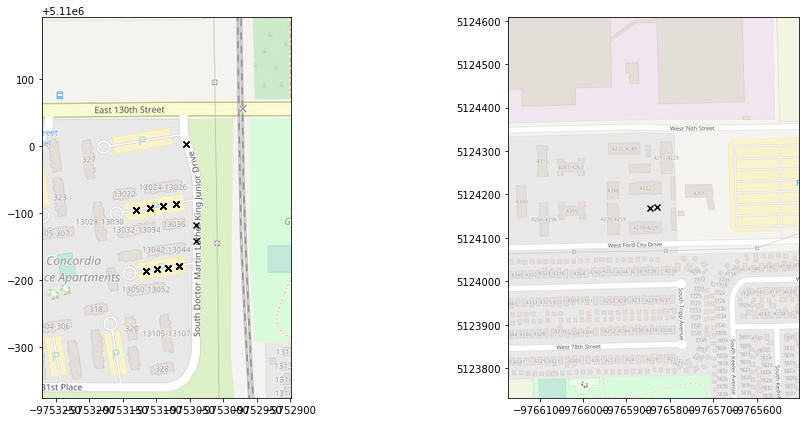

In [27]:
fig, ax = plt.subplots(ncols=2, figsize=(16,7))
plot_block('130XX S DR MARTIN LUTHER KING JR DR', 100, ax[0])
plot_block('042XX W 77TH ST', 2000, ax[1])

## Other strange codings; work in progress

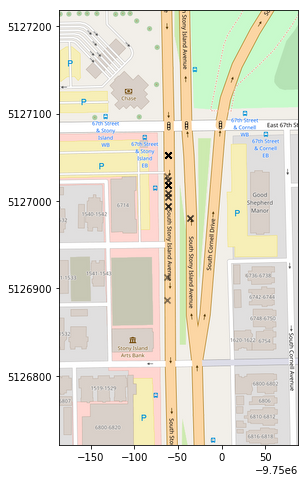

In [28]:
block = frame[frame.address=='067XX S STONY ISLAND AVE']

extent = tilemapbase.extent_from_frame(block, 600, 100)

fig, ax = plt.subplots(figsize=(8,8))
extent.plothq(ax, tilemapbase.tiles.OSM)

x = block.geometry.map(lambda pt : pt.coords[0][0])
y = block.geometry.map(lambda pt : pt.coords[0][1])
ax.scatter(x, y, color="black", marker="x", alpha=0.5)
None

# Looking at the distribution of locations by block

We'll now (re)load the data, project the same way but in meters.  Then for each block, we'll look at the all coordinates.  We'll then translate these to have zero mean (i.e. measure the distance from the centroid).

In [29]:
frame = chicago.load_to_geoDataFrame(empty_geometry="empty")

In [30]:
# Meters units and projection suitable for Illinois
frame = frame.to_crs({"init":"EPSG:3435"})
frame.head()

,address,case,crime,geometry,location,timestamp,type
0,010XX N CENTRAL PARK AVE,HZ560767,OTHER OFFENSE,POINT (1152188.999927331 1906649.000013127),APARTMENT,2016-12-22T02:55:00,VIOLATE ORDER OF PROTECTION
1,051XX S WASHTENAW AVE,HZ561134,BATTERY,POINT (1159241.999998677 1870526.000088323),RESIDENTIAL YARD (FRONT/BACK),2016-12-22T11:17:00,AGGRAVATED: OTHER FIREARM
2,059XX W DIVERSEY AVE,HZ565584,DECEPTIVE PRACTICE,POINT (1136402.999890962 1918002.999887207),RESIDENCE,2016-12-09T12:00:00,FINANCIAL IDENTITY THEFT $300 AND UNDER
3,001XX N STATE ST,HZ561772,THEFT,POINT (1176351.999872658 1900926.999957381),DEPARTMENT STORE,2016-12-22T18:50:00,RETAIL THEFT
4,008XX N MICHIGAN AVE,HZ561969,THEFT,POINT (1177337.999942323 1906212.999921561),SMALL RETAIL STORE,2016-12-22T19:20:00,RETAIL THEFT


In [31]:
frame.location.unique()

array(['APARTMENT', 'RESIDENTIAL YARD (FRONT/BACK)', 'RESIDENCE',
       'DEPARTMENT STORE', 'SMALL RETAIL STORE', 'VACANT LOT/LAND',
       'HOSPITAL BUILDING/GROUNDS', 'OTHER', 'CHA PARKING LOT/GROUNDS',
       'RESIDENCE-GARAGE', 'CHA APARTMENT', 'STREET',
       'SCHOOL, PUBLIC, GROUNDS', 'RESTAURANT', 'ALLEY',
       'PARKING LOT/GARAGE(NON.RESID.)', 'COMMERCIAL / BUSINESS OFFICE',
       'SIDEWALK', 'RESIDENCE PORCH/HALLWAY', '', 'CLEANING STORE',
       'NURSING HOME/RETIREMENT HOME', 'ATM (AUTOMATIC TELLER MACHINE)',
       'VEHICLE NON-COMMERCIAL', 'SCHOOL, PUBLIC, BUILDING', 'LIBRARY',
       'BANK', 'GAS STATION', 'FACTORY/MANUFACTURING BUILDING', 'TAXICAB',
       'GROCERY FOOD STORE', 'GOVERNMENT BUILDING/PROPERTY', 'CTA TRAIN',
       'BARBERSHOP', 'VEHICLE-COMMERCIAL', 'CTA BUS', 'AIRCRAFT',
       'AIRPORT TERMINAL UPPER LEVEL - NON-SECURE AREA', 'ATHLETIC CLUB',
       'AIRPORT VENDING ESTABLISHMENT', 'POLICE FACILITY/VEH PARKING LOT',
       'DRUG STORE', 'CTA PLATFOR

# Find deltas by block

In [32]:
import collections

by_block = collections.defaultdict(list)
for _, row in frame.iterrows():
    if row.geometry.is_empty:
        continue
    #if row.crime not in {"ROBBERY", "THEFT"}:
    #    continue
    by_block[row.address].append( list(row.geometry.coords)[0] )

In [33]:
for key in set(by_block):
    x = np.asarray(by_block[key])
    x -= np.average(x, axis=0)
    by_block[key] = x

# Single out north-south

We choose just the blocks which seem to be north/south (bases on the deltas) and then normalise each block to be in the range [-1,1]

In [34]:
def normalise(x, y):
    value = np.vstack([x,y]).T
    if min(y) >= 0:
        if max(y) == 0:
            raise Exception()
        v = value / max(y)
    elif max(y) <= 0:
        if min(y) == 0:
            raise Exception()
        v = value / (-min(y))
    else:
        m = max(max(y), -min(y))
        if m == 0:
            raise Exception()
        v = value / m
    return v

value = np.asarray([[-1,2],[-3,4],[5,6]])
normalise(value[:,0], value[:,1])

array([[-0.16666667,  0.33333333],
       [-0.5       ,  0.66666667],
       [ 0.83333333,  1.        ]])

In [35]:
ns = []
for key, value in by_block.items():
    x, y = value[:,0], value[:,1]
    if len(x) < 10:
        continue
    dx = max(x) - min(x)
    dy = max(y) - min(y)
    if dy > 10 * dx:
        ns.append(normalise(x,y))

Let's plot all the deltas.  These show a strong north/south bias, as we hope.  They are on an angle, but I believe this is simply because Chicago is aligned not exactly north/south, but also at a slight angle.

That the line is somewhat think I cannot account for.

The clumps at y=-1 and y=1 are statistical artifacts of rescaling the data to exactly fit into [-1,1].

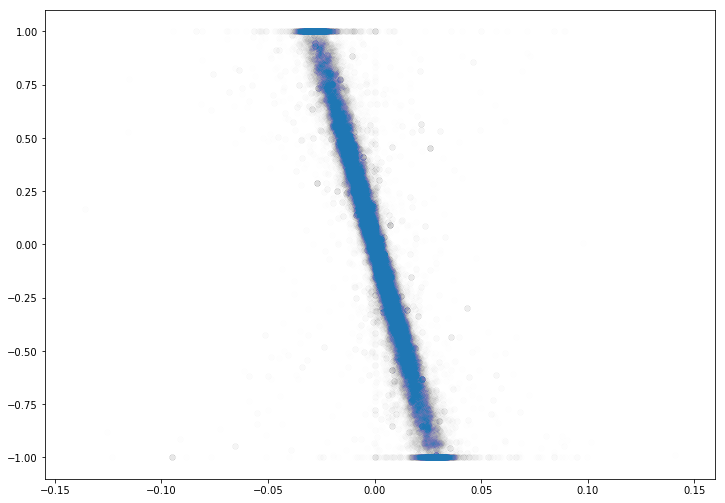

In [36]:
x = np.asarray([x for value in ns for x in value])

fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(x[:,0], x[:,1], alpha=0.002)
ax.set_aspect(.1)
ax.set(ylim=[-1.1,1.1])
None

In [37]:
import scipy.stats

Let's look at the y coordinate only, and use a KDE to estimate the density.

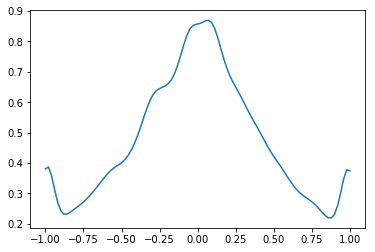

In [38]:
y_marginals = x[:,1]
kernel = scipy.stats.kde.gaussian_kde(y_marginals)

xc = np.linspace(-1,1,100)
plt.plot(xc, kernel(xc))

# Simulate some data

Let's suppose the data really came from a uniform distribution.

- For each entry in `ns` we simulate the same number of points from a uniform distribution
- Convert to having mean zero
- Then re-scale in the same way

We also do this with a normal distribution, instead of a uniform distribution.  This shows much better agreement with the real data, suggesting that maybe a normal distribution is used?

In [39]:
def mean_zero_rescale(values):
    values -= np.average(values)
    v = normalise(np.zeros_like(values), values)
    return v[:,1]

def sim(length):
    values = np.random.random(length)
    return mean_zero_rescale(values)

def sim_gaussian(length):
    values = np.random.normal(size=length)
    return mean_zero_rescale(values)

sim_ns = []

for value in ns:
    length = value.shape[0]
    sim_ns.append(sim_gaussian(length))

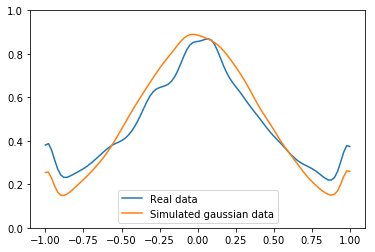

In [40]:
sim_x = np.asarray([x for value in sim_ns for x in value])
kernel_sim = scipy.stats.kde.gaussian_kde(sim_x)

xc = np.linspace(-1,1,100)
plt.plot(xc, kernel(xc))
plt.plot(xc, kernel_sim(xc))
plt.legend(["Real data", "Simulated gaussian data"])
plt.ylim([0,1])
None